# Subsampling mocks
Using Mehdi's [code](https://github.com/mehdirezaie/LSSutils/blob/master/analysis/lssxcmb/scripts/subsample_mock.py).

In [1]:
# %matplotlib inline
import os
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from glob import glob
from time import time
from astropy.table import Table, vstack
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')
#sys.path.append('/global/homes/a/arosado/LSSutils_no_mpi/')
from lssutils import setup_logging, CurrentMPIComm
from lssutils.utils import npix2nside, make_hp
from lssutils.utils import maps_dr9 as columns
import lssutils.utils as ut

In [2]:
# need sysnet env with nbodykit to load this
from lssutils.stats.cl import get_cl,AnaFast
af = AnaFast()
from lssutils.lab import get_meandensity

In [3]:
print(columns)

['EBV', 'STARDENS', 'galdepth_rmag_ebv', 'galdepth_gmag_ebv', 'galdepth_zmag_ebv', 'psfdepth_rmag_ebv', 'psfdepth_gmag_ebv', 'psfdepth_zmag_ebv', 'psfdepth_w1mag_ebv', 'psfdepth_w2mag_ebv', 'PSFSIZE_R', 'PSFSIZE_G', 'PSFSIZE_Z']


In [4]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None, return_hpix=False):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    hpmap = np.bincount(hpix, weights=weight, minlength=12*nside*nside)
    if return_hpix:
        return hpmap, hpix
    else:
        return hpmap
    
def read_data(data, nside=256):
    d_ = data
    ng = ut.make_hp(nside, d_['hpix'], d_['label'])
    nr = ut.make_hp(nside, d_['hpix'], d_['fracgood'])
    mask = ut.make_hp(nside, d_['hpix'], 1.0) > 0.5
    syst = ut.make_hp(nside, d_['hpix'], np.log(d_['features'][:, 0]))
    return ng, nr, mask, syst
    
def normalize_selection_func(ngal_pred):
    # get nside from the selection function
    nside = hp.get_nside(ngal_pred)
    
    # normalize the selection function to [0, 1]
    good = ngal_pred>0
    vmin, vmax = np.percentile(ngal_pred[good], [0, 100])
    selection_func = np.zeros_like(ngal_pred)
    selection_func[good] = (ngal_pred[good]-vmin) / (vmax-vmin)
    return selection_func

def downsample(selection_func, mock):
    """ downsample a mock catalog with a given selection function """
    nside = hp.get_nside(selection_func)
    hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
    prob = selection_func[hpix]    
    good = np.random.uniform(size=mock.size) < prob
    return mock[good]

def _desi_mock_filename(tracer='LRG', ph=0):
    """Collect the name of DESI Mocks in NERSC."""
    mock_dir='/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/'
    z_dic={'LRG':0.8,'ELG':1.1,'QSO':1.4}
    fname=f'{mock_dir}{tracer}/z{z_dic[tracer]:5.3f}/cutsky_{tracer}_z{z_dic[tracer]:5.3f}_AbacusSummit_base_c000_ph{ph:003d}.fits'
    return fname

def _selection_function_filename(tracer='LRG', ind=0):
    """Collect selection function obtained from NN."""
    tracer = tracer.lower() # after testing make a directory by tracer
    fname=f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{ind}.hp256.fits'
    return fname

def _selection_function_filename_mean(tracer='LRG'):
    """Collect selection function obtained from NN."""
    tracer = tracer.lower() # after testing make a directory by tracer
    fname=f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits'
    return fname

def make_hp(hpix, value, nside):
    """ A Function to create a HEALPix map
    """
    m_ = np.zeros(12*nside*nside)
    m_[:] = np.nan
    m_[hpix] = value
    
    return m_

def get_cl_mock(mask, selection_fn=None, nside=256, tracer='LRG', ph=0):

    # read the mock catalog
    mock_name = _desi_mock_filename(tracer=tracer, ph=ph)
    print(f'using {mock_name}')
    mock = ft.read(mock_name)
    mock = mock[mock['STATUS'] & 2**0 != 0]

    # collect randoms
    randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
    randoms = ft.read(randoms_path)
    # keep only randoms with correct n(z) distribution 
    randoms = randoms[randoms['STATUS'] & 2**0 != 0]
    # project randoms to healpix map
    randoms_hmap = project2hp(nside, randoms)
    
    if selection_fn is None:
        # project to HEALPix
        mock_hmap = project2hp(nside, mock)
        # get cl
        cl = get_cl(mock_hmap, randoms_hmap, mask)
    else:
        # normalize the selection function to [0, 1]
        selection_func = normalize_selection_func(selection_fn)
        # subsample the mock catalog, and project to HEALPix
        mock = downsample(selection_func, mock)
        mock_hmap = project2hp(nside, mock)
        # calculate cl
        cl = get_cl(mock_hmap, randoms_hmap, mask)
        
    return cl

def get_mock_hpmap(contaminated=False, selection_fn=None, nside=256, tracer='LRG', ph=0):
    # read the mock catalog
    mock_name = _desi_mock_filename(tracer=tracer, ph=ph)
    mock = ft.read(mock_name)
    mock = mock[mock['STATUS'] & 2**0 != 0]
    
    if contaminated:
        assert selection_fn is not None, "provide selection function"
        # normalize the selection function to [0, 1]
        selection_func = normalize_selection_func(selection_fn)
        # subsample the mock catalog, and project to HEALPix
        mock = downsample(selection_func, mock)
        
    mock_hpmap = project2hp(nside, mock)
    return mock_hpmap

In [5]:
#help(get_cl)

# Maps

In [4]:
regions = ['bmzls','ndecals','sdecals']

# collect real data used to train NN
data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')

# get NN-weights
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits', verbose=False, dtype=None)

In [5]:
%%time 
# stack all regions:
tables = []
for d_fn in data:
    d = Table.read(d_fn)
    #print(len(d))
    tables.append(d)
tables = vstack(tables) 

# get ngal, nran and mask in healpix map
ngal,nran,mask_data,_=read_data(tables, nside=256)

CPU times: user 106 ms, sys: 135 ms, total: 241 ms
Wall time: 313 ms


saving /global/homes/a/arosado/sysgen/plots/hpmaps.png
CPU times: user 16.7 s, sys: 12.7 s, total: 29.4 s
Wall time: 29.9 s


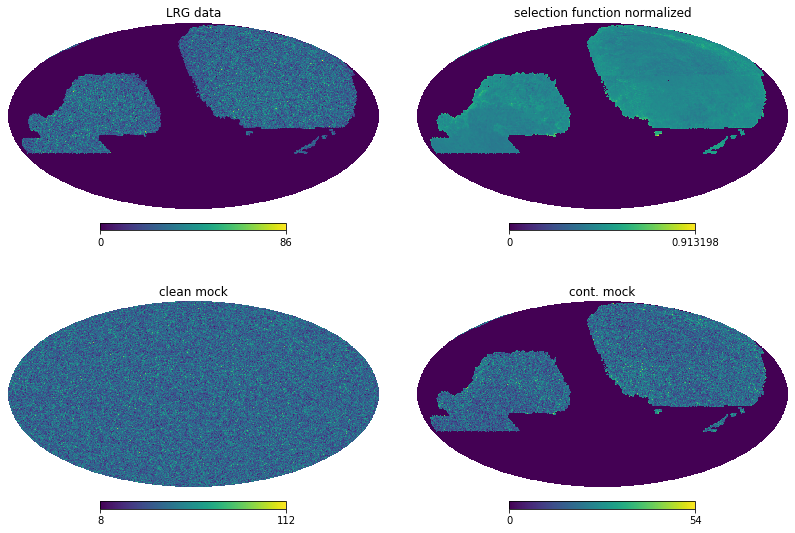

In [18]:
%%time
plot_dir = '/global/homes/a/arosado/sysgen/plots'

fig, ax = plt.subplots(nrows=2, ncols=2)
ax = ax.flatten()
fig.set_size_inches(14, 10)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

plt.sca(ax[0])    
hp.mollview(ngal, title='LRG data', hold=True, rot=-85)

plt.sca(ax[1])
sel_fn = normalize_selection_func(nn_test1)
hp.mollview(sel_fn, title='selection function normalized', hold=True, rot=-85)


ph = 0 # mock number
plt.sca(ax[2])
clean_mock = get_mock_hpmap(ph=ph)
hp.mollview(clean_mock, title='clean mock', hold=True, rot=-85)

plt.sca(ax[3])
cont_mock = get_mock_hpmap(contaminated=True,selection_fn=nn_test1, ph=ph)
hp.mollview(cont_mock, title='cont. mock', hold=True, rot=-85)

fn = os.path.join(plot_dir, f'hpmaps.png')
print(f'saving {fn}')
plt.savefig(fn, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')

# Mean density

Here we compare the mean density vs ebv of the data we used for training the NN and for the mean of the NN results.

In [6]:
regions = ['bmzls','ndecals','sdecals']

data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits', verbose=False, dtype=None)

In [7]:
# stack all regions:
tables = []
for d_fn in data:
    d = Table.read(d_fn)
    #print(len(d))
    tables.append(d)
tables = vstack(tables) 

ngal = tables['label']
nran = tables['fracgood']
mask = np.ones_like(ngal, '?')
sysm = tables['features']

hpix = tables['hpix']

feature: EBV


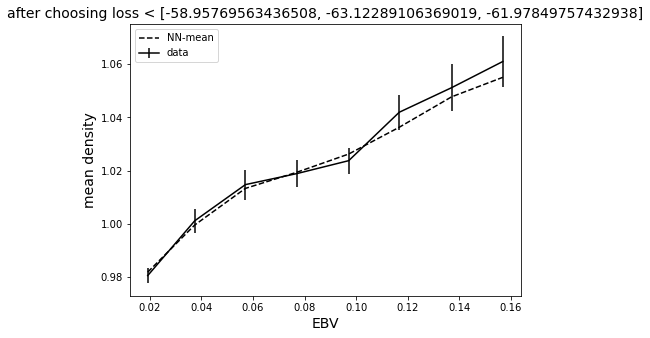

CPU times: user 28.8 s, sys: 605 ms, total: 29.4 s
Wall time: 29.3 s


In [8]:
%%time

nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                             global_nbar=True, njack=20)

nnbar_ls_mean_test1 = get_meandensity(nran*nn_test1[hpix], nran, mask, sysm, 
                                      columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                                      global_nbar=True)
output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results_test1'

col_i = 0 # EBV
print(f'feature: {columns[col_i]}')

fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.ylabel(r'mean density', fontsize=14)
plt.xlabel(f'{columns[col_i]}', fontsize=14)
plt.errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], color='k', label='data')
plt.plot(nnbar_ls_mean_test1[col_i]['bin_avg'], nnbar_ls_mean_test1[col_i]['nnbar'], color='k',ls='--', label='NN-mean')
plt.title("after choosing loss < [-58.95769563436508, -63.12289106369019, -61.97849757432938]", fontsize=14)
#plt.ylim(0.85,1.08)
plt.legend()
plt.show()

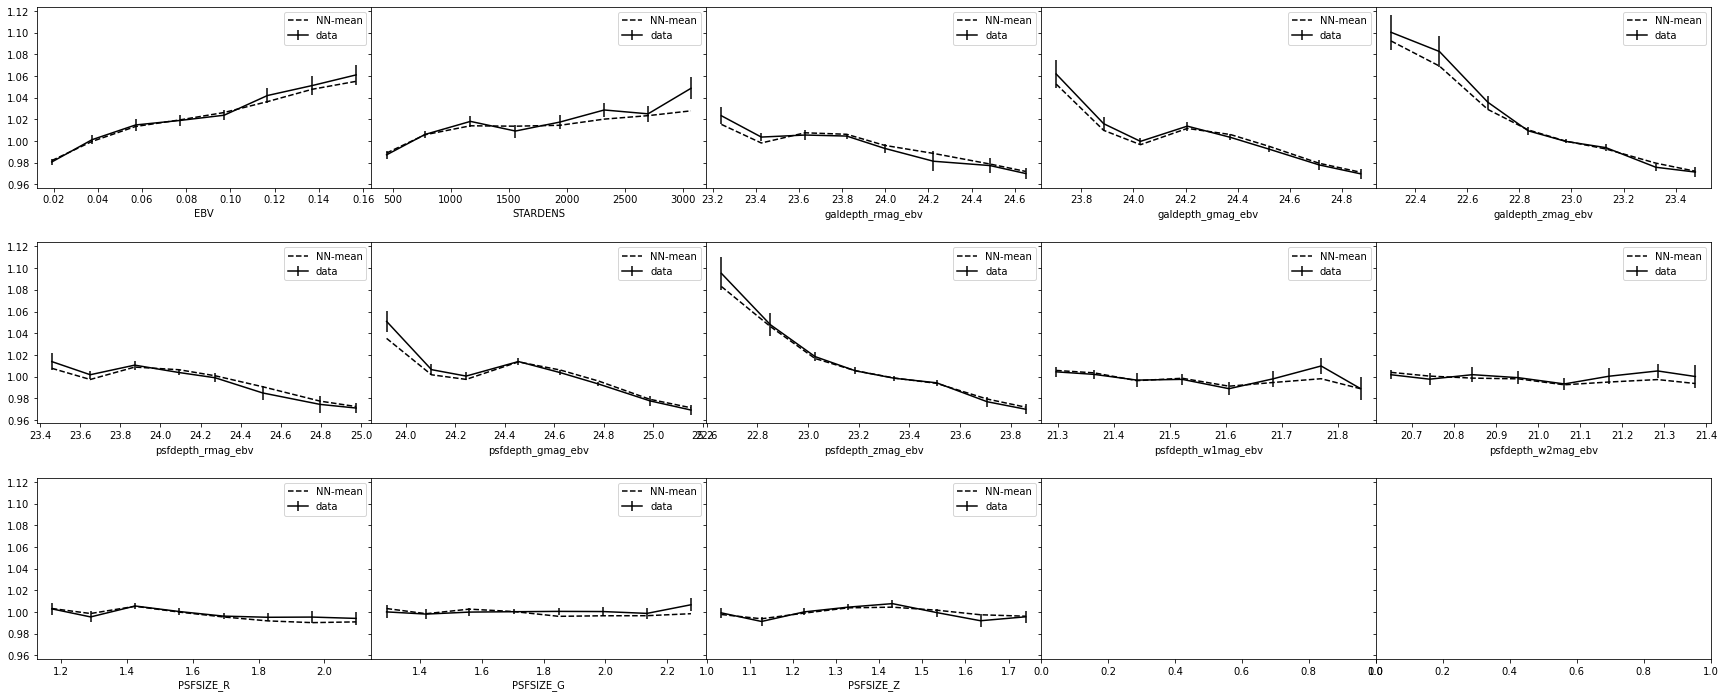

CPU times: user 2.45 s, sys: 336 ms, total: 2.79 s
Wall time: 2.67 s


In [15]:
%%time
fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.3)
plt.rc('figure', facecolor='w')
ax = ax.flatten()

for col_i in range(13):
    ax[col_i].set(xlabel=f'{columns[col_i]}')
    ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], color='k', label='data')
    ax[col_i].plot(nnbar_ls_mean_test1[col_i]['bin_avg'], nnbar_ls_mean_test1[col_i]['nnbar'], color='k',ls='--', label='NN-mean')
    ax[col_i].legend()
plt.show()

# Power Spectrum

## Contaminate a mock with mean NN result and Plot $C_\ell$.

In [6]:
regions = ['bmzls','ndecals','sdecals']

data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits', verbose=False, dtype=None)

In [7]:
%%time 
# collect real data used to train NN
data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')

# stack all regions:
tables = []
for d_fn in data:
    d = Table.read(d_fn)
    #print(len(d))
    tables.append(d)
tables = vstack(tables) 

# get ngal, nran and mask in healpix map
ngal,nran,mask_data,_=read_data(tables, nside=256)

# get cl of real data
cl_real = get_cl(ngal,nran, mask_data)['cl_gg']
ell_real, cell_real, cell_err = ut.histogram_cell(cl_real['l'], cl_real, return_err=True, method='jackknife')

# mitigated cl of real data
cl_mitigated = get_cl(ngal,nran, mask_data, selection_fn=nn_test1)['cl_gg']
ell_mitigated, cell_mitigated, cell_err_mitigated = ut.histogram_cell(cl_mitigated['l'], cl_mitigated, return_err=True, method='jackknife')

CPU times: user 54.7 s, sys: 1.55 s, total: 56.3 s
Wall time: 29.1 s


In [7]:
t0 = time()
# read the mock catalog
mock_name = _desi_mock_filename(tracer='LRG', ph=0)
mock = ft.read(mock_name)
mock = mock[mock['STATUS'] & 2**0 != 0]

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = ft.read(randoms_path)

# keep only randoms with correct n(z) distribution 
randoms = randoms[randoms['STATUS'] & 2**0 != 0]

# read selection function (obtained from real data)
sel_fn = _selection_function_filename_mean(tracer='LRG')
ngal_pred = hp.read_map(sel_fn)

# get nside from the selection function
nside = hp.get_nside(ngal_pred)

# project to HEALPix
mock_before_hmap, hpix_before = project2hp(nside, mock, return_hpix=True)
#mask_before = make_hp(hpix_before , 1.0, nside)
#mask_before = mask_before > 0.5  # to make it binary

# normalize the selection function to [0, 1]
selection_func = normalize_selection_func(ngal_pred)

# subsample the mock catalog, and project to HEALPix
mock_after = downsample(selection_func, mock)
mock_after_hmap, hpix_after = project2hp(nside, mock_after, return_hpix=True)
#mask_after = make_hp(hpix_after , 1.0, nside)
#mask_after = mask_after > 0.5  # to make it binary

# project randoms to healpix map
randoms_hmap = project2hp(nside, randoms)

cl_before = get_cl(mock_before_hmap, randoms_hmap, mask_data)['cl_gg']
ell_before,cell_before,_ = ut.histogram_cell(cl_before['l'], cl_before, return_err=True, method='jackknife')

cl_after = get_cl(mock_after_hmap, randoms_hmap, mask_data)['cl_gg']
ell_after,cell_after,_= ut.histogram_cell(cl_after['l'], cl_after, return_err=True, method='jackknife')

print(f'finished at {time() - t0} s')

/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
finished at 40.6953547000885 s


In [ ]:
fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.errorbar(ell_real, cell_real - cl_real['shotnoise'], yerr=cell_err, color='k',
             marker='.', alpha=1., ls='-', capsize=2, label='real data')
plt.errorbar(ell_mitigated, cell_mitigated - cl_mitigated['shotnoise'], yerr=cell_err_mitigated, color='k',
             marker='.', alpha=1., ls='--', capsize=2, label='mitigated data')


plt.plot(ell_before, cell_before - cl_before['shotnoise'], ls='--', color='r',alpha=0.5)
plt.plot(ell_after, cell_after - cl_after['shotnoise'], ls='-', color='r',alpha=0.5)
    
plt.title('Power Spectrum (shotnoise substracted)', fontsize=18)
plt.plot([],[], ls='--', color='r', label='mock')
plt.plot([],[], ls='-', color='r', label='cont. mock')
plt.legend()
plt.ylabel(r'$C_{\ell}$',fontsize=18)
plt.xlabel(r'$\ell$',fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.ylim(4e-7,1e-2)
plt.show()

In [8]:
t0 = time()
# read the mock catalog
mock_name = _desi_mock_filename(tracer='LRG', ph=0)
mock, h = ft.read(mock_name, header=True)
mock = mock[mock['STATUS'] & 2**0 != 0]

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = ft.read(randoms_path)

# keep only randoms with correct n(z) distribution 
randoms = randoms[randoms['STATUS'] & 2**0 != 0]

# read selection function (obtained from real data)
sel_fn = _selection_function_filename_mean(tracer='LRG')
ngal_pred = hp.read_map(sel_fn)

# get nside from the selection function
nside = hp.get_nside(ngal_pred)

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [9]:
# project to HEALPix
mock_before_hmap, hpix_before = project2hp(nside, mock, return_hpix=True)
mock_after_hmap = mock_before_hmap.copy() 
print(np.array_equal(mock_after_hmap, mock_before_hmap))
mock_after_hmap[hpix_before] = mock_before_hmap[hpix_before] / ngal_pred[hpix_before]#project2hp(nside, mock, weight=1) #mock_before_hmap/ngal_pred
print(np.array_equal(mock_after_hmap, mock_before_hmap))

True
False


In [ ]:
%%time 
# project randoms to healpix map
randoms_hmap = project2hp(nside, randoms)

cl_before = get_cl(mock_before_hmap, randoms_hmap, mask_data)['cl_gg']
ell_before,cell_before,_ = ut.histogram_cell(cl_before['l'], cl_before, return_err=True, method='jackknife')

cl_after = get_cl(mock_after_h, randoms_hmap, mask_data)['cl_gg']
ell_after,cell_after,_= ut.histogram_cell(cl_after['l'], cl_after, return_err=True, method='jackknife')

print(f'finished at {time() - t0} s')

In [11]:
%%time
# read selection function (obtained from real data)
sel_fn = _selection_function_filename_mean(tracer='LRG')
ngal_pred = hp.read_map(sel_fn)

cl_before = get_cl_mock_test(mask_data, selection_fn=None, nside=256, tracer='LRG', ph=0)['cl_gg']
ell_before,cell_before,_ = ut.histogram_cell(cl_before['l'], cl_before, return_err=True, method='jackknife')

cl_after = get_cl_mock_test(mask_data, selection_fn=ngal_pred, nside=256, tracer='LRG', ph=0)['cl_gg']
ell_after,cell_after,_= ut.histogram_cell(cl_after['l'], cl_after, return_err=True, method='jackknife')

/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits


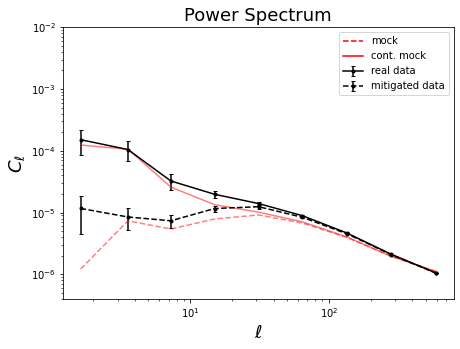

In [12]:
fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.errorbar(ell_real, cell_real, yerr=cell_err, color='k',
             marker='.', alpha=1., ls='-', capsize=2, label='real data')
plt.errorbar(ell_mitigated, cell_mitigated, yerr=cell_err_mitigated, color='k',
             marker='.', alpha=1., ls='--', capsize=2, label='mitigated data')


plt.plot(ell_before, cell_before, ls='--', color='r',alpha=0.5)
plt.plot(ell_after, cell_after, ls='-', color='r',alpha=0.5)
    
plt.title('Power Spectrum', fontsize=18)
plt.plot([],[], ls='--', color='r', label='mock')
plt.plot([],[], ls='-', color='r', label='cont. mock')
plt.legend()
plt.ylabel(r'$C_{\ell}$',fontsize=18)
plt.xlabel(r'$\ell$',fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.ylim(4e-7,1e-2)
plt.show()

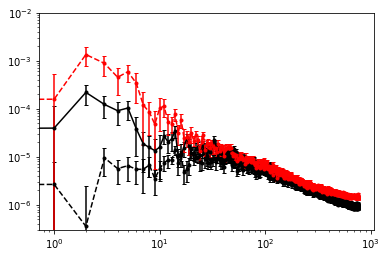

In [10]:
cl_i = cl_before
plt.errorbar(cl_i['l'], cl_i['cl'], yerr=cl_i['cl_error'],
             marker='.', alpha=1., ls='--', capsize=2, color='k')

cl_i = cl_real
plt.errorbar(cl_i['l'], cl_i['cl'], yerr=cl_i['cl_error'],
             marker='.', alpha=1., ls='-', capsize=2, color='k')

cl_i = cl_after
plt.errorbar(cl_i['l'], cl_i['cl'], yerr=cl_i['cl_error'],
             marker='.', alpha=1., ls='--', capsize=2, color='r')

plt.xscale('log')
plt.yscale('log')
plt.ylim(3e-7,1e-2)
plt.show()

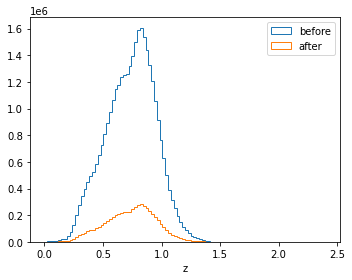

In [17]:
# flag for expected n(z) mock
sel_nz = mock['STATUS'] & 2**0 != 0
sel_nz_ = mock_after['STATUS'] & 2**0 != 0

plt.figure(figsize=(5, 4))
plt.hist(mock['Z'], histtype='step', bins=100, range=(0.0, 2.4), label='before')
plt.hist(mock_after['Z'], histtype='step', bins=100, range=(0.0, 2.4), label='after')
plt.legend()
plt.xlabel('z')
plt.tight_layout()
plt.show()

## Contaminate several mocks with mean NN result and Plot $C_\ell$.

In [8]:
def get_cl_mock_test(mask, selection_fn=None, nside=256, tracer='LRG', ph=0):

    # read the mock catalog
    mock_name = _desi_mock_filename(tracer=tracer, ph=ph)
    print(f'using {mock_name}')
    mock = ft.read(mock_name)
    mock = mock[mock['STATUS'] & 2**0 != 0]

    # collect randoms
    randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
    randoms = ft.read(randoms_path)
    # keep only randoms with correct n(z) distribution 
    randoms = randoms[randoms['STATUS'] & 2**0 != 0]
    # project randoms to healpix map
    randoms_hmap = project2hp(nside, randoms)
    # project to HEALPix
    mock_hmap = project2hp(nside, mock)
    if selection_fn is None:
        # get cl
        cl = get_cl(mock_hmap, randoms_hmap, mask)
    else:
        cl = get_cl(mock_hmap/selection_fn, randoms_hmap, mask)
        
    return cl

In [5]:
regions = ['bmzls','ndecals','sdecals']

data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits', verbose=False, dtype=None)

In [6]:
%%time 
# collect real data used to train NN
data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')

# stack all regions:
tables = []
for d_fn in data:
    d = Table.read(d_fn)
    #print(len(d))
    tables.append(d)
tables = vstack(tables) 

# get ngal, nran and mask in healpix map
ngal,nran,mask_data,_=read_data(tables, nside=256)

# get cl of real data
cl_real = get_cl(ngal,nran, mask_data)['cl_gg']
ell_real, cell_real, cell_err = ut.histogram_cell(cl_real['l'], cl_real, return_err=True, method='jackknife')

# mitigated cl of real data
cl_mitigated = get_cl(ngal,nran, mask_data, selection_fn=nn_test1)['cl_gg']
ell_mitigated, cell_mitigated, cell_err_mitigated = ut.histogram_cell(cl_mitigated['l'], cl_mitigated, return_err=True, method='jackknife')

CPU times: user 52 s, sys: 921 ms, total: 53 s
Wall time: 26.8 s


```
%%time
## snippet for saving cls
import os
output_dir = '/global/cscratch1/sd/arosado/test_sysnet/mock_results/'

# read selection function (obtained from real data)
sel_fn = _selection_function_filename_mean(tracer='LRG')
ngal_pred = hp.read_map(sel_fn)

# contaminated mocks cls
for ph in range(25):
    cl_after = get_cl_mock(mask_data, selection_fn=ngal_pred, nside=256, tracer='LRG', ph=ph)
    output_fn = os.path.join(output_dir, f'cell_cont_mock_ph{ph:003d}.hp256.npy')
    print(f'saving {output_fn}')
    #np.save(output_fn, cl_after)
    
# mocks cls
for ph in range(25):
    cl_before = get_cl_mock(mask_data, selection_fn=None, nside=256, tracer='LRG', ph=ph)
    output_fn = os.path.join(output_dir, f'cell_mock_ph{ph:003d}.hp256.npy')
    print(f'saving {output_fn}')
    #np.save(output_fn, cl_before)
```

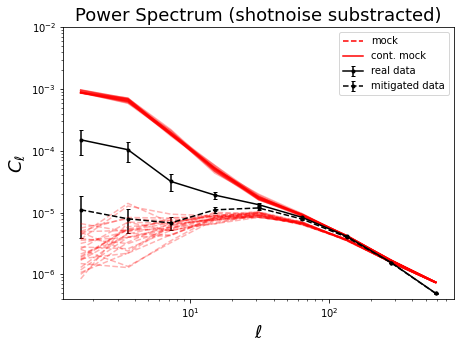

In [7]:
output_dir = '/global/cscratch1/sd/arosado/test_sysnet/mock_results/'

fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.errorbar(ell_real, cell_real - cl_real['shotnoise'], yerr=cell_err, color='k',
             marker='.', alpha=1., ls='-', capsize=2, label='real data')
plt.errorbar(ell_mitigated, cell_mitigated - cl_mitigated['shotnoise'], yerr=cell_err_mitigated, color='k',
             marker='.', alpha=1., ls='--', capsize=2, label='mitigated data')

for ph in range(25):
    cl_before = np.load(os.path.join(output_dir, f'cell_mock_ph{ph:003d}.hp256.npy'), allow_pickle=True).item()['cl_gg']
    ell_before,cell_before,_ = ut.histogram_cell(cl_before['l'], cl_before, return_err=True, method='jackknife')
    
    cl_after = np.load(os.path.join(output_dir, f'cell_cont_mock_ph{ph:003d}.hp256.npy'), allow_pickle=True).item()['cl_gg']
    ell_after,cell_after,_= ut.histogram_cell(cl_after['l'], cl_after, return_err=True, method='jackknife')

    plt.plot(ell_before, cell_before - cl_before['shotnoise'], ls='--', color='r',alpha=0.3)
    plt.plot(ell_after, cell_after - cl_after['shotnoise'], ls='-', color='r',alpha=0.3)
    
plt.title('Power Spectrum (shotnoise substracted)', fontsize=18)
plt.plot([],[], ls='--', color='r', label='mock')
plt.plot([],[], ls='-', color='r', label='cont. mock')
plt.legend()
plt.ylabel(r'$C_{\ell}$',fontsize=18)
plt.xlabel(r'$\ell$',fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.ylim(4e-7,1e-2)
plt.show()